(content:references:spectra_part4)=
# Stellar Spectra Part 4: *Detecting Stellar Activity Indicators*

***Author: Marc Hon***

In this Section, we will examine how autoencoding techniques can be useful to find stars of interest, namely those showing peculiar spectral features.


In [143]:
import os
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec

from pathlib import Path
from astropy.io import fits
from matplotlib import cm
from matplotlib.colors import Normalize
from copy import copy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from torch import nn

data_folder_path = Path.cwd().resolve().parent.parent / 'ml_astro' / 'chapter2' / 'data'

plt.style.use('science')

fs = 18

## Spectral Activity Indicators

In magnetically active stars, the chromosphere is heated by magnetic reconnection and related non-radiative processes. This enhanced heating increases the rate of collisional excitation and de-excitation, particularly of atoms and ions that form spectral features in the chromospheric layers. These spectral lines act as powerful diagnostics of stellar magnetic activity, revealing localized heating in the outer atmosphere.

In this section, we examine two such widely used activity indicators:

- **Hydrogen alpha (H-$\alpha$):**  The H-α line is part of the Balmer series of hydrogen, produced by electrons transitioning from the $n=3$ to $n=2$ energy level. It typically appears as a strong absorption feature at 6562.8 Å. In magnetically active stars, increased chromospheric heating can lead to net emission of H-α photons, resulting in either filling-in of the absorption core or full emission profiles.


-  **Ca II InfraRed Triplet (IRT)**: The Ca II IRT consists of three transitions of singly ionized calcium at approximately 8498, 8542, and 8662 Å. These lines usually appear in absorption in cool stars and are formed in the lower chromosphere. In active stars, the line cores can become partially or fully filled with emission.

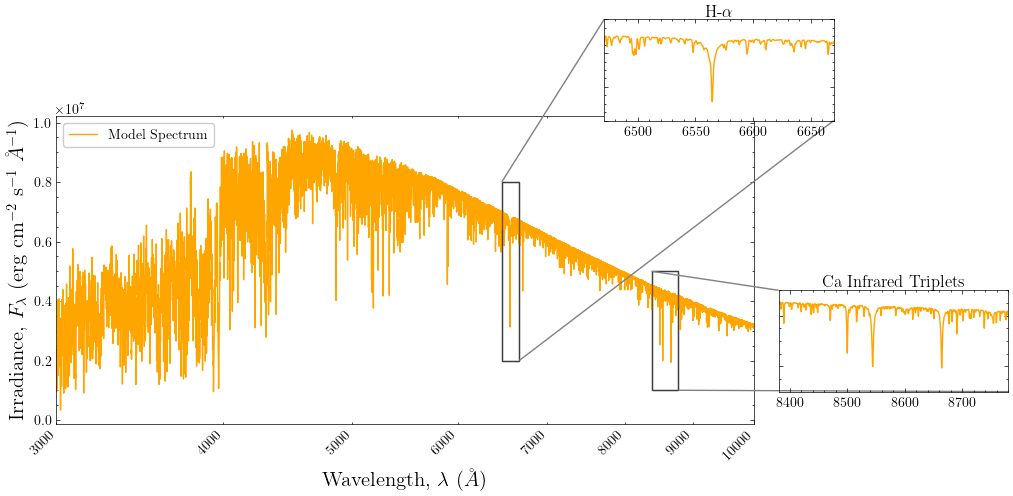

In [2]:
wav = np.arange(2000, 40000) * u.AA

flux_conv = u.erg/u.s/(u.cm*u.cm)/u.AA
flux_conv2 = u.erg/u.s/(u.cm*u.cm)/u.cm
ph_wav_lr = fits.open(str(data_folder_path) + '/model_spectra/lte05700-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')
xlim_min, xlim_max = 2000, 40000

fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_subplot(111)

ax1.plot(ph_wav_lr[0].header['CRVAL1'] + np.arange(ph_wav_lr[0].header['NAXIS1'])*ph_wav_lr[0].header['CDELT1'],
           ph_wav_lr[0].data*flux_conv2.to(flux_conv), color='orange',
        label='Model Spectrum')
ax1.set_xlabel('Wavelength, $\\lambda$ ($\\AA$)', fontsize=fs-3)
ax1.set_ylabel('Irradiance, $F_\\lambda$ (erg cm$^{-2}$ s$^{-1}$ $\\AA^{-1}$)', fontsize=fs-3)
ax1.set_xlim(xlim_min, xlim_max)
ax1.get_xticklabels()
ax1.set_xscale('log')
ax1.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax1.xaxis.set_minor_formatter(mticker.ScalarFormatter())
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.legend(frameon=1, framealpha=1)
ax1.set_xlim(3000, 10000)

ax1a = inset_axes(ax1, width="47%", height="47%", loc='center',
                  bbox_to_anchor=(0.6, 0.8, 0.7, 0.7),
                  bbox_transform=ax1.transAxes)
ax1a.plot(ph_wav_lr[0].header['CRVAL1'] + np.arange(ph_wav_lr[0].header['NAXIS1'])*ph_wav_lr[0].header['CDELT1'],
           ph_wav_lr[0].data*flux_conv2.to(flux_conv), color='orange')
ax1a.set_title('H-$\\alpha$', pad=0.1)
ax1a.set_xlim(6471, 6670)
ax1a.set_ylim(0.2e7, 0.8e7); ax1a.set_yticklabels([])
ax1.indicate_inset_zoom(ax1a, edgecolor="black")
mark_inset(ax1, ax1a, loc1=2, loc2=4, fc="none", ec="0.5");

ax1b = inset_axes(ax1, width="47%", height="47%", loc='center',
                  bbox_to_anchor=(0.85, -0.08, 0.7, 0.7),
                  bbox_transform=ax1.transAxes)
ax1b.plot(ph_wav_lr[0].header['CRVAL1'] + np.arange(ph_wav_lr[0].header['NAXIS1'])*ph_wav_lr[0].header['CDELT1'],
           ph_wav_lr[0].data*flux_conv2.to(flux_conv), color='orange')
ax1b.set_title('Ca Infrared Triplets', pad=0.1)
ax1b.set_xlim(8381,8780)
ax1b.set_ylim(0.1e7, 0.5e7); ax1b.set_yticklabels([])
ax1.indicate_inset_zoom(ax1b, edgecolor="black")
mark_inset(ax1, ax1b, loc1=2, loc2=4, fc="none", ec="0.5");

ax1.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax1.xaxis.set_minor_formatter(mticker.ScalarFormatter())
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
for label in ax1.get_xminorticklabels():
    label.set_rotation(45)
    label.set_ha('right')

plt.show()

In moderate to high-resolution spectra with reasonable signal-to-noise levels, the presence of emission within these lines are fairly easy to detect.

```{figure} images/HalphaMRS.png
---
height: 400px
width: 700px
name: halphamrs
---
H$\alpha$ emission lines for nine different stars from LAMOST Medium Resolution Spectra reported by [He et al. (2023)](https://link.springer.com/article/10.1007/s10509-023-04219-w). Each column corresponds to a different spectral type, indicative of the temperature of the star (hotter stars to the left). The vertical band in each panel marks the  center band of the H$\alpha$ line, whose mean flux is compared with the flux from the continuum (green bands) to calculate the activity indicator $I_{\mathrm{H}\alpha}$.
```

In this activity, we are going to be using a dataset of low-resolution spectra from the Large Sky Area Multi-Object Fiber Spectroscopic Telescope (**LAMOST**). These spectra have a resolution of 1800 at 5500 Å and have a wavelength range of 370-900nm. Meanwhile, the selection for targets will be for those with temperatures between $3000-8500\,$K and a minimum signal-to-noise ratio of 10.

In [178]:
mrs_data = np.load(str(data_folder_path) + '/LAMOST_MRS_Activity.npz')

## Halpha Line ##
wave_ha = mrs_data['wave_ha']; flux_ha = mrs_data['flux_ha']; flux_ha_active = mrs_data['flux_ha_active']

## Calcium Triplets ##
wave_ca = mrs_data['wave_ca']; flux_ca = mrs_data['flux_ca']; flux_ca_active = mrs_data['flux_ca_active']

The dataset includes both active and inactive spectra, as shown in the following:

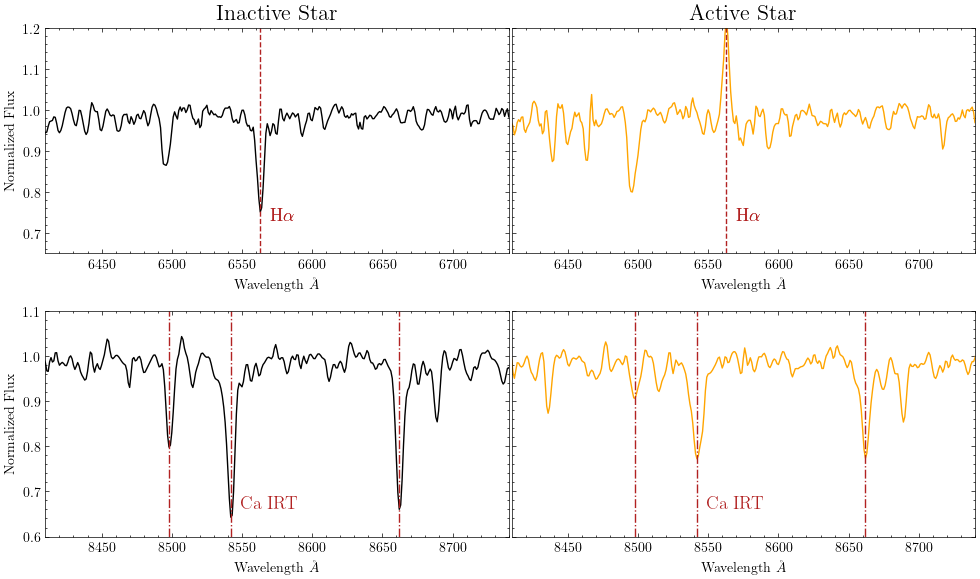

In [4]:
fig = plt.figure(figsize=(10, 6))
ax1, ax1a = fig.add_subplot(221), fig.add_subplot(223)
ax2, ax2a = fig.add_subplot(222), fig.add_subplot(224)

idx = 14

ax1.plot(wave_ha, flux_ha[idx], c='k'); ax1a.plot(wave_ca, flux_ca[idx], c='k')
ax2.plot(wave_ha, flux_ha_active[idx], c='orange'); ax2a.plot(wave_ca, flux_ca_active[idx], c='orange')
ax1.set_ylim(0.65, 1.2); ax2.set_ylim(0.65, 1.2)
ax1a.set_ylim(0.6, 1.1); ax2a.set_ylim(ax1a.get_ylim())
ax1.set_xlim(6410, 6740); ax2.set_xlim(ax1.get_xlim())
ax1a.set_xlim(8410, 8740); ax2a.set_xlim(ax1a.get_xlim())
ax2.set_yticklabels([]); ax2a.set_yticklabels([])
ax1.set_ylabel('Normalized Flux'); ax1a.set_ylabel('Normalized Flux')
[ax.set_xlabel('Wavelength $\\AA$') for ax in [ax1, ax1a, ax2, ax2a]]
[ax.axvline(x=6562.8, c='firebrick', ls='--') for ax in [ax1, ax2]]
[ax1a.axvline(x=k, c='firebrick', ls='-.') for k in [8498, 8542,8662]]; [ax2a.axvline(x=k, c='firebrick', ls='-.') for k in [8498, 8542,8662]]
[ax.text(x=0.485, y=0.15, fontsize=fs-5, s='H$\\alpha$', transform=ax.transAxes, color='firebrick') for ax in [ax1, ax2]]
[ax.text(x=0.485, y=0.15, fontsize=fs-5, s='H$\\alpha$', transform=ax.transAxes, color='firebrick') for ax in [ax1, ax2]]
[ax.text(x=0.42, y=0.125, fontsize=fs-5, s='Ca IRT', transform=ax.transAxes, color='firebrick') for ax in [ax1a, ax2a]]
ax1.set_title('Inactive Star', fontsize=fs-2); ax2.set_title('Active Star', fontsize=fs-2)
plt.tight_layout(w_pad=0.2)

```{admonition} The Challenge of Simple Metrics
:class: tip
Notice that Hα can sometimes appear in full emission above the continuum, while the Ca IRT lines show only reduced absorption depth in active stars. These differing morphological responses to magnetic activity highlight why it can be oversimplistic to rely on integrated the flux within the Hα band without consideration of the other spectral signatures of the star.

The detectability of activity signatures must be also interpreted in relation to the surrounding continuum and other global stellar parameters, such as effective temperature, surface gravity, metallicity, and rotational broadening.
```

## Autoencoding Stellar Spectra

The traditional approach to detecting and measuring chromospheric emission from a star's spectrum is to subtract an inactive copy of the spectrum from the observed data. This process, known as **spectral subtraction**, typically requires [synthesizing quiet template spectra](https://www.aanda.org/articles/aa/full_html/2015/03/aa24409-14/aa24409-14.html), which is a large computational burden for the analysis of millions of spectra collected by large surveys such as LAMOST.

A data-driven approach provides a computationally efficient alternative to traditional spectral modeling. By training an autoencoder to reconstruct quiet stellar spectra, it learns to capture the underlying structure of normal stellar atmospheres. Once trained, the autoencoder can rapidly generate template spectra for new observations, implicitly accounting for both global stellar parameters and the characteristic spectral features of each star.


```{figure} images/vae_magnetic.png
---
height: 400px
width: 650px
name: vaemagnetic
---
A schematic of the variational autoencoder used for this analysis. Image from [Yue et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022MNRAS.514.4781X/abstract).
```

Let's define the tools required to train a **variational autoencoder** on the spectra.

In [132]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

X = np.concatenate( [np.expand_dims(flux_ha, -1), np.expand_dims(flux_ca, -1)], 2)
X_active = np.concatenate( [np.expand_dims(flux_ha_active, -1), np.expand_dims(flux_ca_active, -1)], 2)

X_quiet = torch.tensor(X, dtype=torch.float32)
X_active = torch.tensor(X_active, dtype=torch.float32)
active_dataset = TensorDataset(X_active)

val_fraction = 0.1  # 10 % of the quiet data is randomly held out for validation
dataset_size = len(X_quiet)
val_size = int(val_fraction * dataset_size)
train_size = dataset_size - val_size

train_dataset, val_dataset = random_split(
    TensorDataset(X_quiet),
    lengths=[train_size, val_size],
    generator=torch.Generator().manual_seed(42) 
)

dataloader_quiet_train = DataLoader(train_dataset, batch_size=64, shuffle=True)
dataloader_quiet_val = DataLoader(val_dataset, batch_size=64, shuffle=False)
dataloader_active = DataLoader(active_dataset, batch_size=64, shuffle=False)

In [6]:
## Defining the training objective -- MSE Loss and KL Divergence

def vae_loss(recon_x, x, mu, log_var, beta=1.0):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + beta * kl_div

Next, we define the variational autoencoder model.

In [7]:
class VAE(nn.Module):
    def __init__(self, input_size, num_hidden1=512, num_hidden2=256, num_hidden3=128, code_size=4, drop_rate=0.2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, num_hidden1),nn.PReLU(),nn.Dropout(p=drop_rate),
            nn.Linear(num_hidden1, num_hidden2),nn.PReLU(),nn.Dropout(p=drop_rate),
            nn.Linear(num_hidden2, num_hidden3),nn.PReLU(),nn.Dropout(p=drop_rate)
        )
        self.hidden2mu = nn.Linear(num_hidden3, code_size)
        self.hidden2log_var = nn.Linear(num_hidden3, code_size)
        self.decoder = nn.Sequential(
            nn.Linear(code_size, num_hidden3),nn.PReLU(),nn.Dropout(p=drop_rate),
            nn.Linear(num_hidden3, num_hidden2),nn.PReLU(),nn.Dropout(p=drop_rate),
            nn.Linear(num_hidden2, num_hidden1),nn.PReLU(),nn.Dropout(p=drop_rate),
            nn.Linear(num_hidden1, input_size),
        )

    def reparameterization(self, mu, log_var):
        if self.training:
            std = torch.exp(0.5*log_var)
            epsilon = torch.randn_like(std)
            z = mu + std*epsilon
            return z
        else:
            return mu

    def forward(self, x):
        x = self.encoder(x)
        mu = self.hidden2mu(x)
        log_var = self.hidden2log_var(x)
        z = self.reparameterization(mu, log_var)
        z = self.hidden2mu(x)
        x = self.decoder(z)
        return x, mu, log_var

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE(input_size=flux_ha.shape[1]*2, num_hidden1 = 64,
            num_hidden2=32, num_hidden3=16,
            code_size=2, drop_rate=0).to(device)

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

In [9]:
num_epochs = 15000
beta = 1

for epoch in range(num_epochs):
    total_loss = 0
    val_loss = 0

    model.train()
    for batch in dataloader_quiet_train:
        x = batch[0]
        x2 = torch.cat([x[:, :, 0], x[:, :, 1]], dim=1).to(device)
        optimizer.zero_grad()
        recon_x, mu, log_var = model(x2)
        loss = vae_loss(recon_x, x2, mu, log_var, beta=beta)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader_quiet_train.dataset)
    
    if epoch % 1000 == 0:
        model.eval()  ## Perform Validation ##
        with torch.no_grad():
            for batch in dataloader_quiet_val:
                x = batch[0]
                x2 = torch.cat([x[:, :, 0], x[:, :, 1]], dim=1  ).to(device)
                recon_x, mu, log_var = model(x2)
                loss = vae_loss(recon_x, x2, mu, log_var, beta=beta)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(dataloader_quiet_val.dataset)
    
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch 1/15000, Train Loss: 728.4055, Val Loss: 667.4794
Epoch 1001/15000, Train Loss: 0.0914, Val Loss: 0.0830
Epoch 2001/15000, Train Loss: 0.0776, Val Loss: 0.0698
Epoch 3001/15000, Train Loss: 0.0691, Val Loss: 0.0652
Epoch 4001/15000, Train Loss: 0.0711, Val Loss: 0.0649
Epoch 5001/15000, Train Loss: 0.0964, Val Loss: 0.0875
Epoch 6001/15000, Train Loss: 0.0691, Val Loss: 0.0640
Epoch 7001/15000, Train Loss: 0.0691, Val Loss: 0.0655
Epoch 8001/15000, Train Loss: 0.0663, Val Loss: 0.0654
Epoch 9001/15000, Train Loss: 0.0646, Val Loss: 0.0645
Epoch 10001/15000, Train Loss: 0.0658, Val Loss: 0.0633
Epoch 11001/15000, Train Loss: 0.0661, Val Loss: 0.0635
Epoch 12001/15000, Train Loss: 0.0624, Val Loss: 0.0628
Epoch 13001/15000, Train Loss: 0.0634, Val Loss: 0.0632
Epoch 14001/15000, Train Loss: 0.0624, Val Loss: 0.0660


Let's visualize these reconstructions of the autoencoder:

In [176]:
val_recons, active_recons = [], []
val_truth, active_truth = [], []
val_mu, active_mu = [], []
model.eval()  
with torch.no_grad():
    for batch in dataloader_quiet_val:
        x = batch[0]
        x2 = torch.cat([x[:, :, 0], x[:, :, 1]], dim=1  ).to(device)
        recon_x, mu, log_var = model(x2)
        val_recons.append(recon_x.cpu())
        val_truth.append(x2.cpu())
        val_mu.append(mu.cpu())
    for batch in dataloader_active:
        x = batch[0]
        x2 = torch.cat([x[:, :, 0], x[:, :, 1]], dim=1  ).to(device)
        recon_x, mu, log_var = model(x2)
        active_recons.append(recon_x.cpu())
        active_truth.append(x2.cpu())
        active_mu.append(mu.cpu())
val_recons, active_recons = np.concatenate(val_recons), np.concatenate(active_recons)     
val_truth, active_truth = np.concatenate(val_truth), np.concatenate(active_truth)       
val_mu, active_mu = np.concatenate(val_mu), np.concatenate(active_mu)     

In [130]:
def compare_recons(idx, val_recons, val_truth, active_recons, active_truth):
    fig = plt.figure(figsize=(10, 6))
    
    gs = gridspec.GridSpec(nrows=8, ncols=2, hspace=0.15)
    ax1, ax1a = fig.add_subplot(gs[:2, 0]), fig.add_subplot(gs[:2, 1])
    ax1_r, ax1a_r = fig.add_subplot(gs[2, 0]), fig.add_subplot(gs[2, 1])

    hspace = fig.add_subplot(gs[3:5, :]); hspace.axis('off')
    
    ax2, ax2a = fig.add_subplot(gs[5:7, 0]), fig.add_subplot(gs[5:7, 1])
    ax2_r, ax2a_r = fig.add_subplot(gs[7, 0]), fig.add_subplot(gs[7, 1])

    ax1.plot(wave_ha, val_truth[idx, :400], c='k', label='Observed'); ax1a.plot(wave_ca, val_truth[idx, 400:], c='k')
    ax1.plot(wave_ha, val_recons[idx, :400], c='r', label='Reconstruction'); ax1a.plot(wave_ca, val_recons[idx, 400:], c='r')
    ax1_r.plot(wave_ha, val_truth[idx, :400]- val_recons[idx, :400], c='orange')
    ax1a_r.plot(wave_ca, val_truth[idx, 400:] - val_recons[idx, 400:], c='orange')
    
    ax2.plot(wave_ha, active_truth[idx, :400], c='k', label='Observed'); ax2a.plot(wave_ca, active_truth[idx, 400:], c='k')
    ax2.plot(wave_ha, active_recons[idx, :400], c='r', label='Reconstruction'); ax2a.plot(wave_ca, active_recons[idx, 400:], c='r')

    ax2_r.plot(wave_ha, active_truth[idx, :400]- active_recons[idx, :400], c='orange')
    ax2a_r.plot(wave_ca, active_truth[idx, 400:] - active_recons[idx, 400:], c='orange')
    
    ax1.set_ylim(0.625, 1.4); ax2.set_ylim(ax1.get_ylim())
    ax1a.set_ylim(0.6, 1.1); ax2a.set_ylim(ax1a.get_ylim())
    ax1.set_xlim(6410, 6740); ax2.set_xlim(ax1.get_xlim())
    ax1a.set_xlim(8410, 8740); ax2a.set_xlim(ax1a.get_xlim())
    ax2a_r.set_xlim(ax2a.get_xlim()); ax2_r.set_xlim(ax2.get_xlim()); ax1_r.set_xlim(ax1.get_xlim()) ; ax1a_r.set_xlim(ax1a.get_xlim())
    
    [ax.set_ylim(-0.025, 0.25) for ax in [ax1_r, ax1a_r, ax2_r, ax2a_r]]
    [ax.text(x=0.5, y=0.65, s='Observed - Reconstructed', transform=ax.transAxes, color='goldenrod') for ax in [ax1_r, ax1a_r, ax2_r, ax2a_r]]
    
    [ax.set_xticklabels([]) for ax in [ax1, ax1a, ax2, ax2a]]
    [ax.set_ylabel('Normalized Flux') for ax in [ax1,ax1a,ax2,ax2a]]
    [ax.set_xlabel('Wavelength $\\AA$') for ax in [ax1_r, ax1a_r, ax2_r, ax2a_r]]
    ax1.set_title('Quiet Validation Sample', fontsize=fs-2, x=1.1); ax2.set_title('Active Star Sample', fontsize=fs-2, x=1.1)
    [ax.legend(frameon=1,framealpha=1) for ax in [ax1,ax2]]
    
    ha_lines = [6553, 6573]; ca_lines = [8493, 8503, 8537, 8547, 8657, 8667]
    [ax.axvline(x=l, c='k', ls='-.') for l in ha_lines for ax in [ax1_r, ax2_r]]
    [ax.axvline(x=l, c='k', ls='-.') for l in ca_lines for ax in [ax1a_r, ax2a_r]]

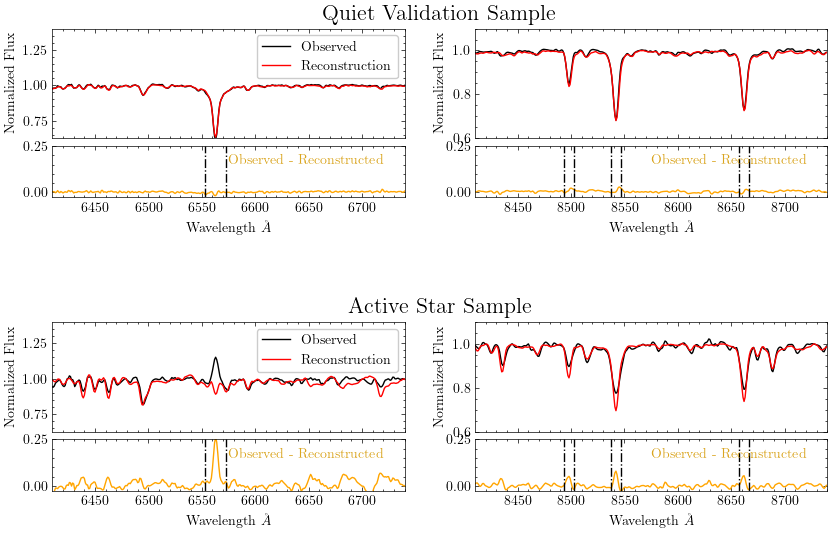

In [231]:
idx = 23
compare_recons(idx, val_recons, val_truth, active_recons, active_truth)

The autoencoder learns how to reproduce quiet spectra well. In the presence of an active star, the autoencoder's outputs are interpreted as the prediction of what a quiet spectrum of that star would look like **given context from other regions of that star's spectrum.**

## Detecting Anomalous Spectral Features -- Equivalent Width

By subtracting the predicted quiet spectrum template from the observed spectrum, we can compute the excess flux from emission in the residuals by computing the **equivalent width** of the relevant spectral lines. This is simply the integral of the residual flux over the wavelengths of the H$\alpha$ and Ca IRT lines, as indicated by the regions between the dashed dotted lines.

In [141]:
def calc_ha_emission(wave, flux, flux_vae):
    window_int = (wave >= 6553) & (wave <= 6573)
    ew_act = np.trapz(flux[window_int] - flux_vae[window_int], wave[window_int], 
                      np.diff(wave)[0])
    return ew_act

def calc_irt_emission(wave, flux, flux_vae):
    window_int = [ ((wave >= 8493) & (wave <= 8503)),
                   ((wave >= 8537) & (wave <= 8547)),
                ((wave >= 8657) & (wave <= 8667)) ]
    ew_act = 0
    for wint in window_int:
        ew_act += np.trapz(flux[wint] - flux_vae[wint], wave[wint], 
                      np.diff(wave)[0])
    return ew_act

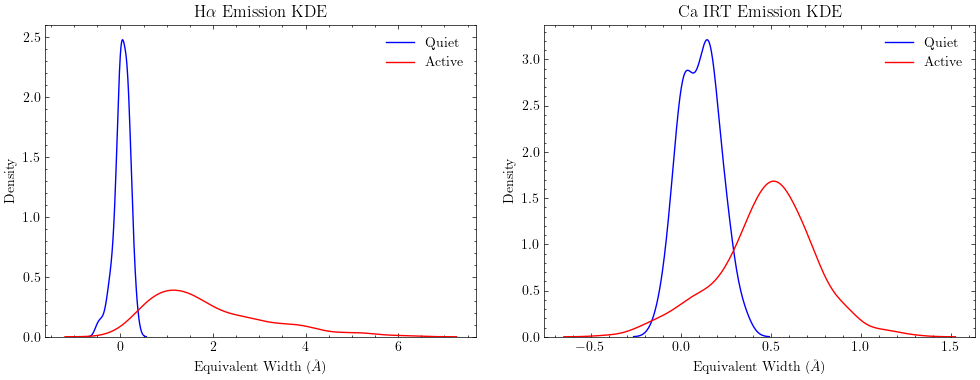

In [157]:
ha_ews_quiet, irt_ews_quiet = [], []
ha_ews_active, irt_ews_active = [], []

for pred, tru in zip(val_recons, val_truth):
    ha_ews_quiet.append( calc_ha_emission(wave_ha, tru[:400], pred[:400]) )
    irt_ews_quiet.append( calc_irt_emission(wave_ca, tru[400:], pred[400:]) )

for pred, tru in zip(active_recons, active_truth):
    ha_ews_active.append( calc_ha_emission(wave_ha, tru[:400], pred[:400]) )
    irt_ews_active.append( calc_irt_emission(wave_ca, tru[400:], pred[400:]) )
    
fig = plt.figure(figsize=(10, 4))
ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)

# H-alpha KDEs
sns.kdeplot(ha_ews_quiet, ax=ax1, label='Quiet', color='blue', fill=False)
sns.kdeplot(ha_ews_active, ax=ax1, label='Active', color='red', fill=False)
ax1.set_title("H$\\alpha$ Emission KDE")
ax1.set_xlabel('Equivalent Width ($\\AA$)')
ax1.legend()

# Ca II IRT KDEs
sns.kdeplot(irt_ews_quiet, ax=ax2, label='Quiet', color='blue', fill=False)
sns.kdeplot(irt_ews_active, ax=ax2, label='Active', color='red', fill=False)
ax2.set_title("Ca IRT Emission KDE")
ax2.set_xlabel('Equivalent Width ($\\AA$)')
ax2.legend()

plt.tight_layout(w_pad=2)
plt.show()

The combination of both measurements provides a useful diagnostic to identify stars that show enhanced magnetic activity:

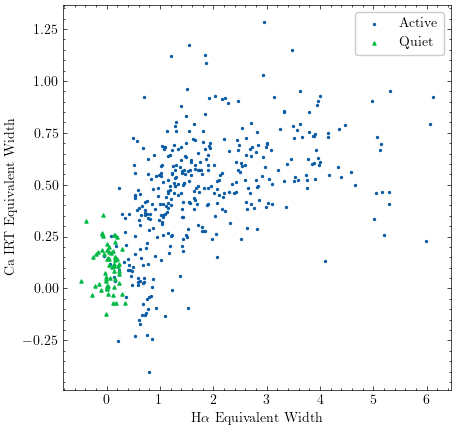

In [164]:
fig = plt.figure(figsize=(5,5))
plt.scatter(ha_ews_active,irt_ews_active, s=2, label='Active')
plt.scatter(ha_ews_quiet,irt_ews_quiet, s=5, marker='^', label='Quiet')
plt.ylabel('Ca IRT Equivalent Width')
plt.xlabel('H$\\alpha$ Equivalent Width'); plt.legend(frameon=1, framealpha=1); plt.show()

Because we used a variational autoencoder, we may expect some structural differences in the latent space between our quiet stars and the active stars.

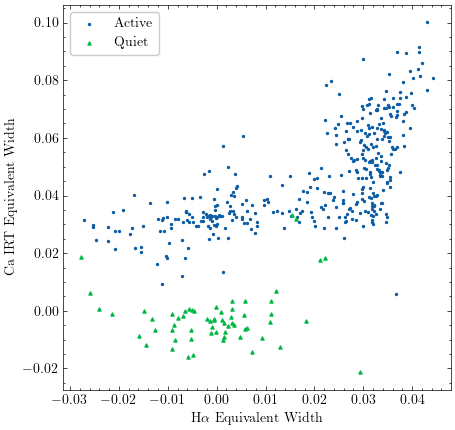

In [177]:
fig = plt.figure(figsize=(5,5))
plt.scatter(active_mu[:,0],active_mu[:,1], s=2, label='Active')
plt.scatter(val_mu[:,0],val_mu[:,1], s=5, marker='^', label='Quiet')
plt.ylabel('Latent Dimension 2')
plt.xlabel('Latent Dimension 1'); plt.legend(frameon=1, framealpha=1); plt.show()


`````{admonition} Exercise
1. Using the equivalent widths (EWs) of H$\alpha$ and the Ca II IRT lines as features, train a simple classifier (e.g., logistic regression, support vector machine, or random forest) to distinguish between active and quiet stars.
2. Repeat the classification task using metrics derived from your trained autoencoder or variational autoencoder—specifically:

    - The reconstruction loss
    - The (negative) log probability under the model:
    
    $\log p(z) = -\frac{1}{2} \left( 2 \log(2\pi) + \sum_{i=1}^2 z_i^2 \right)$,
    
    where $z$ is the latent variable.

3. Evaluate which features yield better separability. Is the log probability an effective indicator of spectra with anomalous features? If not, why so?

`````

## Label Transfer

The data used in this Section has considerably lower resolution compared to those seen in [](content:references:spectra_part1) and [](content:references:spectra_part2). Modern stellar astrophysics relies on an ensemble of large spectroscopic surveys, each with distinct instrumental setups, spectral resolutions, signal-to-noise ratios, and calibration pipelines. Because of this, even when the same star is observed in multiple surveys, its inferred properties may differ due to systematic differences in data quality or pipeline methodology.

In many cases, some surveys (e.g., those with higher resolution) may produce labels that are demonstrably more reliable. To that end, we would like to **calibrate** the labels of the less trusted survey based on the more reliable one. In other words, we transfer the label scale of the more trusted survey onto that of a less reliable one.

To see this, let's consider a toy example of the same dataset, but at a lower resolution and is un-normalized around the H$\alpha$ spectral feature.

In [179]:
lrs_data = np.load(str(data_folder_path) + '/LAMOST_LRS_Activity.npz')
wave_R250 = lrs_data['wave_R250']; flux_R250 = lrs_data['flux_R250']; flux_R250_active = lrs_data['flux_R250_active']

In [195]:
def plot_lrs(idx):
    fig = plt.figure(figsize=(11, 4))
    ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
    ax1.plot(wave_R250, flux_R250[idx], c='k')
    ax2.plot(wave_R250, flux_R250_active[idx], c='orange')
    # ax1.set_ylim(0.65, 1.2); ax2.set_ylim(0.65, 1.2)
    ax1.set_xlim(6000, 7500); ax2.set_xlim(ax1.get_xlim())
    ax1.set_ylabel('Flux'); ax2.set_ylabel('Normalized Flux')
    [ax.set_xlabel('Wavelength $\\AA$') for ax in [ax1, ax2]]
    [ax.axvline(x=6562.8, c='firebrick', ls='--') for ax in [ax1, ax2]]
    [ax.text(x=0.405, y=0.15, fontsize=fs-5, s='H$\\alpha$', transform=ax.transAxes, color='firebrick') for ax in [ax1, ax2]]
    [ax.text(x=0.405, y=0.15, fontsize=fs-5, s='H$\\alpha$', transform=ax.transAxes, color='firebrick') for ax in [ax1, ax2]]
    ax1.set_title('Inactive Star', fontsize=fs-2); ax2.set_title('Active Star', fontsize=fs-2)
    plt.tight_layout(w_pad=1)

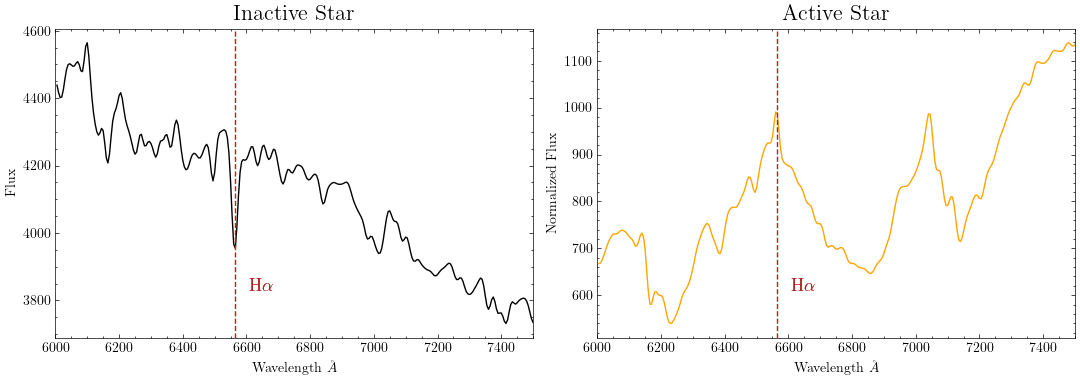

In [196]:
idx = 141
plot_lrs(idx)

Let's proceed as before, training an autoencoder on the low-resolution spectra.

```{note} 
Extra care should be taken for the flux scale, given that these low-resolution spectra are not normalized. Here we use `tslearn`'s `TimeSeriesScalerMeanVariance` to normalize **each** spectrum to have zero mean and unit variance. This is **not** the same as applying `scikit-learn`'s `StandardScaler`, which will instead perform a pixel-by-pixel normalization, such that the flux values at a particular pixel/wavelength **across the dataset** is normally distributed.
```


In [197]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

scaler_r250 = TimeSeriesScalerMeanVariance()

inp_r250_flux = scaler_r250.fit_transform(flux_R250)
active_r250_flux = scaler_r250.transform(flux_R250_active)

X_tensor = torch.tensor(inp_r250_flux, dtype=torch.float32)
X_tensor_active = torch.tensor(active_r250_flux, dtype=torch.float32)

val_fraction = 0.1
dataset_size = len(X_tensor)
val_size = int(val_fraction * dataset_size)
train_size = dataset_size - val_size

train_dataset, val_dataset = random_split(
    TensorDataset(X_tensor),
    lengths=[train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # for reproducibility
)

dataloader_r250_train = DataLoader(train_dataset, batch_size=64, shuffle=True)
dataloader_r250_val = DataLoader(val_dataset, batch_size=64, shuffle=False)
dataloader_r250_active = DataLoader(TensorDataset(X_tensor_active), batch_size=64, shuffle=False)

In [198]:
code_size=2
model_r250 = VAE(input_size=flux_R250.shape[1], num_hidden1 = 64,
            num_hidden2=32, num_hidden3=16,
            code_size=code_size, drop_rate=0).to(device)
optimizer = optim.Adam(model_r250.parameters(), lr=1e-3)

In [199]:
num_epochs = 15000
beta = 1

for epoch in range(num_epochs):
    total_loss = 0
    val_loss = 0

    model.train()
    for batch in dataloader_r250_train:
        x = batch[0].to(device).squeeze(2)
        optimizer.zero_grad()
        recon_x, mu, log_var = model_r250(x)
        loss = vae_loss(recon_x, x, mu, log_var, beta=beta)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader_r250_train.dataset)
    
    if epoch % 1000 == 0:
        model.eval()  ## Perform Validation ##
        with torch.no_grad():
            for batch in dataloader_r250_val:
                x = batch[0].to(device).squeeze(2)
                recon_x, mu, log_var = model_r250(x)
                loss = vae_loss(recon_x, x, mu, log_var, beta=beta)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(dataloader_quiet_val.dataset)
    
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch 1/15000, Train Loss: 295.8449, Val Loss: 280.2026
Epoch 1001/15000, Train Loss: 4.0944, Val Loss: 3.7203
Epoch 2001/15000, Train Loss: 3.0727, Val Loss: 4.5231
Epoch 3001/15000, Train Loss: 2.4577, Val Loss: 4.5844
Epoch 4001/15000, Train Loss: 2.2555, Val Loss: 4.6865
Epoch 5001/15000, Train Loss: 2.1033, Val Loss: 5.1448
Epoch 6001/15000, Train Loss: 1.9143, Val Loss: 5.4187
Epoch 7001/15000, Train Loss: 1.8337, Val Loss: 5.2826
Epoch 8001/15000, Train Loss: 1.8053, Val Loss: 5.1539
Epoch 9001/15000, Train Loss: 1.7823, Val Loss: 4.9016
Epoch 10001/15000, Train Loss: 1.6940, Val Loss: 5.0102
Epoch 11001/15000, Train Loss: 1.6025, Val Loss: 5.0028
Epoch 12001/15000, Train Loss: 1.7330, Val Loss: 5.2744
Epoch 13001/15000, Train Loss: 1.5640, Val Loss: 5.2879
Epoch 14001/15000, Train Loss: 1.5860, Val Loss: 5.3906


In [211]:
val_recons_r250, active_recons_r250 = [], []
val_truth_r250, active_truth_r250 = [], []
model_r250.eval()  
with torch.no_grad():
    for batch in dataloader_r250_val:
        x = batch[0].to(device).squeeze(2)
        recon_x, mu, log_var = model_r250(x)
        val_recons_r250.append(recon_x.cpu())
        val_truth_r250.append(x.cpu())
    for batch in dataloader_r250_active:
        x = batch[0].to(device).squeeze(2)
        recon_x, mu, log_var = model_r250(x)
        active_recons_r250.append(recon_x.cpu())
        active_truth_r250.append(x.cpu())
val_recons_r250, active_recons_r250 = np.concatenate(val_recons_r250), np.concatenate(active_recons_r250)     
val_truth_r250, active_truth_r250 = np.concatenate(val_truth_r250), np.concatenate(active_truth_r250)       

In [232]:
def compare_recons_lrs(idx, val_recons, val_truth, active_recons, active_truth):
    fig = plt.figure(figsize=(10, 4))
    
    gs = gridspec.GridSpec(nrows=3, ncols=2, hspace=0.15)
    ax1, ax1a = fig.add_subplot(gs[:2, 0]), fig.add_subplot(gs[:2, 1])
    ax1_r, ax1a_r = fig.add_subplot(gs[2, 0]), fig.add_subplot(gs[2, 1])


    ax1.plot(wave_R250, val_truth[idx, :], c='k', label='Observed'); ax1a.plot(wave_R250, active_truth[idx, :], c='k')
    ax1.plot(wave_R250, val_recons[idx, :], c='r', label='Reconstruction'); ax1a.plot(wave_R250, active_recons[idx, :], c='r')
    ax1_r.plot(wave_R250, val_truth[idx, :]- val_recons[idx, :], c='orange')
    ax1a_r.plot(wave_R250, active_truth[idx, :] - active_recons[idx, :], c='orange')

    ax1_r.set_xlim(ax1.get_xlim()) ; ax1a_r.set_xlim(ax1a.get_xlim())
    
    [ax.set_ylim(-0.5, 0.5) for ax in [ax1_r, ax1a_r]]
    [ax.text(x=0.5, y=0.65, s='Observed - Reconstructed', transform=ax.transAxes, color='goldenrod') for ax in [ax1_r, ax1a_r]]
    
    [ax.set_xticklabels([]) for ax in [ax1, ax1a]]
    [ax.set_ylabel('Normalized Flux') for ax in [ax1,ax1a]]
    [ax.set_xlabel('Wavelength $\\AA$') for ax in [ax1_r, ax1a_r]]
    ax1.set_title('Quiet Validation Sample', fontsize=fs-2); ax1a.set_title('Active Star Sample', fontsize=fs-2)
    [ax.legend(frameon=1,framealpha=1) for ax in [ax1]]
    
    ha_lines = [6553, 6573]
    [ax.axvline(x=l, c='k', ls='-.', alpha=0.25) for l in ha_lines for ax in [ax1_r, ax1a_r]]

As indicated, the differences in resolution and data processing may result in systematic differences in the reconstruction quality, and subsequently measurements like equivalent widths.

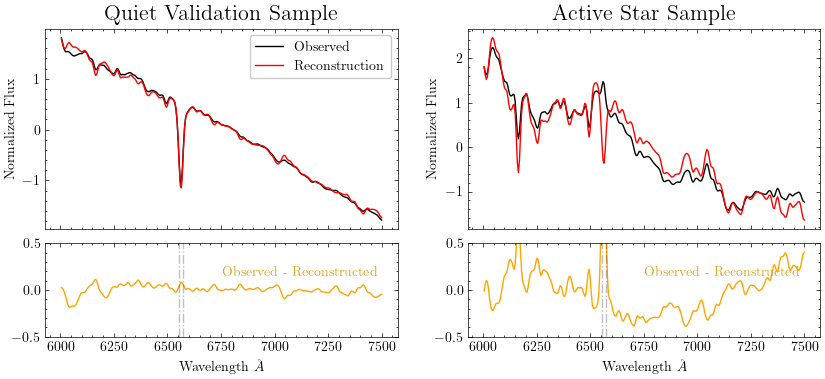

In [233]:
idx = 23
compare_recons_lrs(idx, val_recons_r250, val_truth_r250, active_recons_r250, active_truth_r250)

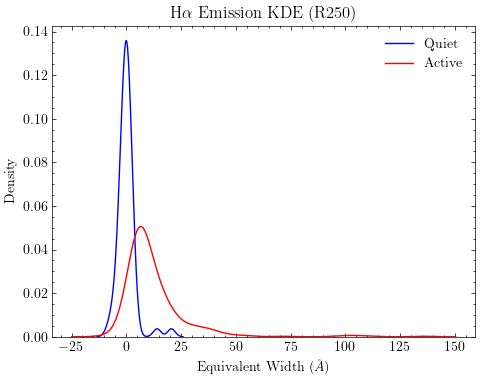

In [237]:
ha_ews_r250_quiet, ha_ews_r250_active = [], []
 
for pred, tru in zip(val_recons_r250, val_truth_r250):
    ha_ews_r250_quiet.append( calc_ha_emission(wave_R250, tru, pred) )

for pred, tru in zip(active_recons_r250, active_truth_r250):
    ha_ews_r250_active.append( calc_ha_emission(wave_R250, tru, pred) )
    
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_subplot(111)
# H-alpha KDEs
sns.kdeplot(ha_ews_r250_quiet, ax=ax1, label='Quiet', color='blue', fill=False)
sns.kdeplot(ha_ews_r250_active, ax=ax1, label='Active', color='red', fill=False)
ax1.set_title("H$\\alpha$ Emission KDE (R250)")
ax1.set_xlabel('Equivalent Width ($\\AA$)')
ax1.legend()

plt.tight_layout(w_pad=2)
plt.show()

As shown in the KDE, the data-driven spectral subtraction method then also loses some of its diagnostic power in separating quiet stars from active stars.

However, by learning a **mapping** from the lower quality data to the higher quality data, we can reduce systematic discrepancies in the derived labels. The following plot shows that a correlation exists between the medium- and low-resolution-derived equivalent widths, and so this can be leveraged to derive a **label transfer model** to convert measurements from low-resolution data to medium-resolution ones.

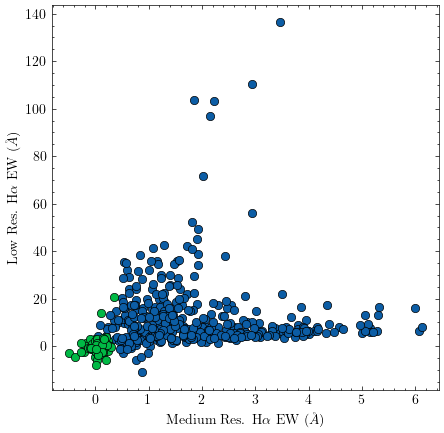

In [247]:
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(111)

ax1.scatter(ha_ews_active, ha_ews_r250_active, label='Active', lw=0.5, edgecolor='k')
ax1.scatter(ha_ews_quiet, ha_ews_r250_quiet, label='Quiet', lw=0.5, edgecolor='k')
ax1.set_xlabel('Medium Res. H$\\alpha$ EW ($\\AA$)')
ax1.set_ylabel('Low Res. H$\\alpha$ EW ($\\AA$)')
plt.show()

```{admonition} Exercise: Label Transfer for Activity Classification
:class: tip

In this exercise, you will investigate how label transfer can help mitigate the loss of discriminative power caused by lower spectral resolution.

1. **Classification from Medium-Resolution EWs**  
   Use the H$\alpha$ equivalent widths derived from medium-resolution, normalized spectra to classify stars as *active* or *quiet*. Apply a simple classifier (e.g., logistic regression, decision tree, or support vector machine), and report the classification accuracy or AUC.

2. **Classification from Low-Resolution EWs**  
   Repeat the classification task using H$\alpha$ EWs measured from the low-resolution, unnormalized spectra. Compare performance with the medium-resolution case. How much discriminative power is lost?

3. **Label Transfer and Improved Classification**  
   Using objects observed in both resolution regimes, fit a simple model (e.g., linear regression) to map low-resolution EWs onto the medium-resolution EW scale. Apply this mapping to the full low-resolution set, and then re-run the classifier using the **transferred** EWs.  
   
   > Does the classification performance improve after label transfer? What does this suggest about the utility of simple domain alignment techniques for heterogeneous spectroscopic data?
   
   
Data-driven models like *The Cannon* have been used to [transfer labels](https://ui.adsabs.harvard.edu/abs/2017ApJ...836....5H/abstract) from higher resolution surveys like APOGEE ($R\sim22,500$) to lower resolution surveys like LAMOST ($R\sim1,800$). This has allowed the extraction of astrophysical information from lower-quality spectra even when their wavelength coverage or resolution precludes direct access to the same spectral features.

In this exercise, this is equivalent to predicting the Ca IRT equivalent widths for the low resolution data, despite the absence of their absorption lines from the observed wavelength range.
   
Label transfer achieves this by **learning correlations** between the Ca IRT and accessible features, such as H$\alpha$. However, caution is warranted: the model must not merely memorize correlations from the training set. Instead, it should generalize from spectral features that retain physical sensitivity to the target label. including line asymmetries, continuum shape, or nearby metal lines that co-vary with activity. Otherwise, the transfer risks becoming a statistical interpolation without physical grounding.

```
